# Preliminaries

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from kneed import KneeLocator


plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#Load original dataframes
allDataCohort = pd.read_csv("../Data Validation/ARIC/Original DataFrames/AllDataAricCohort.csv", sep=",", index_col='ID')
allDataComm = pd.read_csv("../Data Validation/ARIC/Original DataFrames/AllDataAricComm.csv", sep=",", index_col='ID') 
hemoCohort = pd.read_csv("../Data Validation/ARIC/Original DataFrames/HemoAricCohort.csv", sep=",", index_col='ID') 
hemoComm = pd.read_csv("../Data Validation/ARIC/Original DataFrames/HemoAricComm.csv", sep=",", index_col='ID') 
cohortLabels = pd.read_csv("../Data Validation/ARIC/Original DataFrames/LabelsAricCohort.csv", sep=",", index_col='ID')
commLabels = pd.read_csv("../Data Validation/ARIC/Original DataFrames/LabelsAricComm.csv", sep=",", index_col='ID')


# Cluster Labels

In [3]:
#CLUSTERING FUNCTIONS
def clusterFindK(X): #find optimal num k
    sum_of_squared_distances = []
    silhouette = []
    K = range(1,16)
    for k in K:
        k_means = KMeans(n_clusters=k, init='k-means++',n_init=50, max_iter=500, tol=1e-04, random_state=0)
        model = k_means.fit(X)
        sum_of_squared_distances.append(k_means.inertia_)
        if k != 1:
            silhouette.append(silhouette_score(X, k_means.labels_))
        

    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('K Number of Clusters')
    plt.ylabel('Sum of Squared Error')
    plt.title('Elbow Method to Find Optimal K')
    plt.show()
    
    kl = KneeLocator(K, sum_of_squared_distances, curve="convex", direction="decreasing")
    print("Using the elbow method, the optimal number of clusters is", kl.elbow)
    
    plt.plot(range(2,16), silhouette)
    plt.xlabel("K Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
    
    print("Using Silhouette Scores, the optimal number of clusters is", silhouette.index(max(silhouette))+2)
    
def kMeans(X, K): #perform k means clustering
    km = KMeans(n_clusters=K, init='k-means++',n_init=50, max_iter=500, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)
    print("Lowest SSE", km.inertia_) #lowest sum of squared error value
    print("Number of iterations needed for convergence", km.n_iter_) #number of iterations neded to converge
    print("Y_km labels", y_km)
    
    return y_km

def plotPCAClusters(X, y_km, K, name): #plot clusters from pca
    df = pd.DataFrame(X, columns=["Component_1", "Component_2"])
    df['Cluster'] = y_km + 1
    plt.figure(figsize=(16,7))
    sns.scatterplot(x='Component_1', y='Component_2', hue='Cluster', palette=sns.color_palette('hls', K), data=df, legend='full')
    plt.title("Resulting Score Clusters")
    plt.savefig("Figures/Score_Clusters_" + name + ".png")

    plt.show()
    
    return df

def plotClusters(X, y_km, columns, K): #plot original data clusters
    X['cluster'] = y_km
    plt.figure(figsize=(16,7))
    sns.scatterplot(x=columns[0], y=columns[1], hue='cluster',palette=sns.color_palette('hls', K), data=X, legend='full')
    plt.show()
    
    return X

def compareClusters(dt, K): #compare details of clusters
    clusters = []
    clusterDesc = []
    for num in range(K):
        cls = dt[dt['cluster'] == num]
        clusters.append(cls)

        print("Cluster ", num)
        print(cls.describe())
        clusterDesc.append(cls.describe())
        
    return clusters, clusterDesc

#compare distributions of clusters
def distPlotsForClusters(cls, cols, name):
    clusters = copy.deepcopy(cls)
    for c in cols:
        f, ax = plt.subplots(figsize=(11,9))
        for i in range(len(clusters)):
            currCls = pd.DataFrame(clusters[i])
            currCls = currCls.replace(np.inf, 0)
            sns.distplot(currCls[c], ax=ax, label=i)
        
        plt.title(c+ ' Distribution by Cluster')
        plt.ylabel("Distribution Value")
        plt.legend(title="Cluster")
        
        plt.savefig("Figures/" + name + "/Clusters"+c+".png")

## Hemo Dataset - Cohort

In [4]:
#try clustering to find similar groups using PCA
hemo = copy.deepcopy(hemoCohort)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)
scaler = MinMaxScaler()#scale data
hemo.loc[:,:] = scaler.fit_transform(hemo)
pca = PCA(n_components=2)
data = pca.fit_transform(hemo)

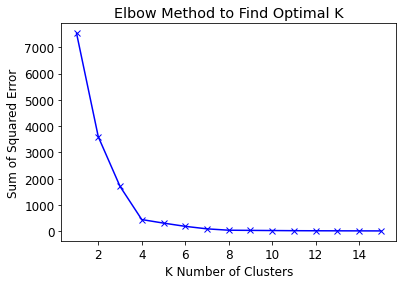

Using the elbow method, the optimal number of clusters is 4


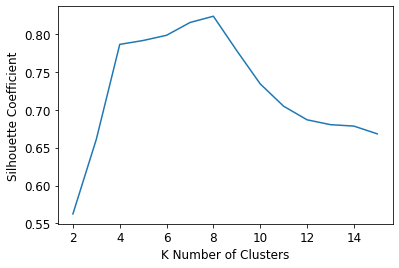

Using Silhouette Scores, the optimal number of clusters is 8


In [5]:
clusterFindK(data)

Lowest SSE 311.88594016234384
Number of iterations needed for convergence 3
Y_km labels [1 1 0 ... 0 1 1]


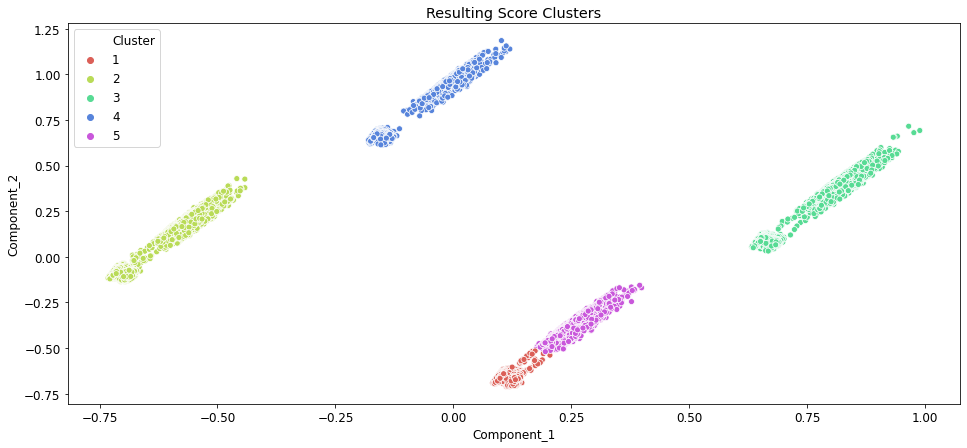

In [6]:
y_km = kMeans(data, 5)
pcaDF = plotPCAClusters(data, y_km, 5, "Hemo_ARIC_Cohort")

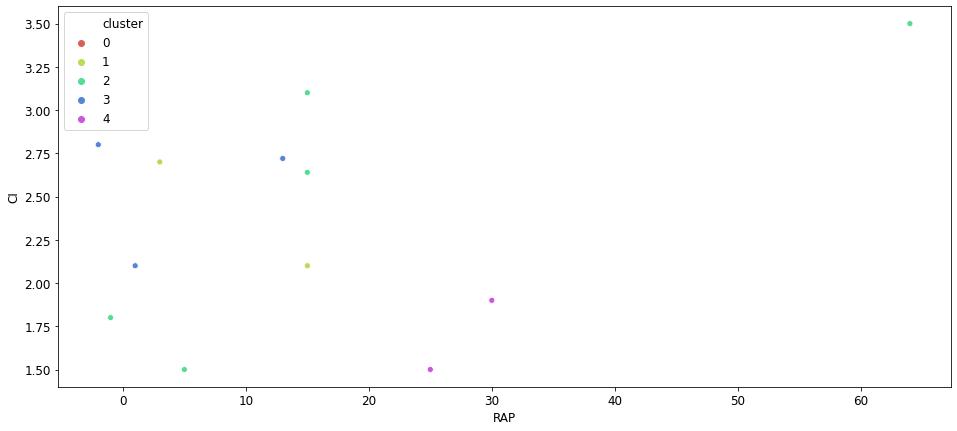

In [7]:
hemoDF = plotClusters(hemoCohort, y_km, ["RAP", "CI"], 5)

In [8]:
#Add class labels
hemoDF['Death'] = cohortLabels['Death']

clusters, clusterDesc = compareClusters(hemoDF, 5)

Cluster  0
               Age  Gender    Race          EjF  RAP  PAS     PAD    PAMN  \
count  2689.000000  2689.0  2689.0  1179.000000  0.0  0.0  2689.0  2689.0   
mean     78.900335     2.0     1.0    50.295165  NaN  NaN     0.0     0.0   
std       6.143960     0.0     0.0    14.582977  NaN  NaN     0.0     0.0   
min      62.000000     2.0     1.0    10.000000  NaN  NaN     0.0     0.0   
25%      75.000000     2.0     1.0    40.000000  NaN  NaN     0.0     0.0   
50%      79.000000     2.0     1.0    55.000000  NaN  NaN     0.0     0.0   
75%      83.000000     2.0     1.0    60.000000  NaN  NaN     0.0     0.0   
max      93.000000     2.0     1.0    95.000000  NaN  NaN     0.0     0.0   

       PCWP   CO  ...    PAPP  SVR  RAT   PPRatio    PAPi  SAPi  CPP  PRAPRat  \
count   0.0  0.0  ...  2689.0  0.0  0.0  5.000000  2689.0   0.0  0.0      0.0   
mean    NaN  NaN  ...     0.0  NaN  NaN  0.421573     0.0   NaN  NaN      NaN   
std     NaN  NaN  ...     0.0  NaN  NaN  0.510607   

Cluster  4
               Age  Gender    Race          EjF        RAP         PAS  \
count  2539.000000  2539.0  2539.0  1197.000000   8.000000    8.000000   
mean     78.523434     2.0     1.0    49.851295  19.500000   67.750000   
std       6.290804     0.0     0.0    14.700338   9.149551   27.384824   
min      61.000000     2.0     1.0    10.000000   8.000000   42.000000   
25%      74.000000     2.0     1.0    40.000000  13.250000   51.750000   
50%      79.000000     2.0     1.0    55.000000  20.000000   59.500000   
75%      83.000000     2.0     1.0    60.000000  26.250000   75.500000   
max      93.000000     2.0     1.0    95.000000  30.000000  110.000000   

          PAD    PAMN       PCWP       CO  ...    PAPP          SVR       RAT  \
count  2539.0  2539.0   8.000000  4.00000  ...  2539.0     4.000000  8.000000   
mean      0.0     0.0  22.250000  2.70000  ...     0.0  3609.931034  0.940285   
std       0.0     0.0   8.924285  0.23094  ...     0.0   531.790205  0.467858  

In [9]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_Hemo_ARIC_Cohort.csv")

In [10]:
hemoDF.to_csv("Clustered_HemoDF_ARIC_Cohort.csv")

Save preprocessed data  
Cluster --> Score   

In [11]:
#Get means for each cluster

clsScDF = pd.DataFrame()
clsScDF.index.name = 'Cluster'

scores = [1,2,3,4,5]
dthMn = descSummary.loc['mean']['Death'].to_numpy()

In [12]:
dthScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(dthMn):
    dthScores[v] = scores[cnt]
    cnt += 1
    
clsScDF['DeathMean'] = dthMn
clsScDF['DeathScores'] = dthScores

clsScDF

,DeathMean,DeathScores
0,0.049833,1
1,0.071819,5
2,0.051578,2
3,0.068160,4
4,0.054352,3


Make sure to add final scores assignment

In [13]:
#Save fully preprocessed score data
clusNums = hemoDF['cluster']

#Death Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['DeathScores']))
hemoDF['ScoreDeath'] = labels

hemoDF = hemoDF.drop(columns=["cluster"])
hemoDF = hemoDF.drop(columns=["Death"])


hemoDF

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,PPP,PAPP,SVR,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,ScoreDeath
ID,,,,,,,,,,,,,,,,,,,,,
S105655,76,1,1,NaN,NaN,NaN,0,0,NaN,NaN,...,0.546392,0,NaN,NaN,1.492958,0,NaN,NaN,NaN,5
S105655,76,1,1,NaN,NaN,NaN,0,0,NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,5
S105737,76,2,1,40.0,NaN,NaN,0,0,NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,1
S105737,76,2,1,40.0,NaN,NaN,0,0,NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,1
S106083,66,2,1,NaN,NaN,NaN,0,0,NaN,NaN,...,0.507042,0,NaN,NaN,0.734694,0,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S214744,74,2,1,NaN,NaN,NaN,0,0,NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,1
S214752,80,2,1,60.0,NaN,NaN,0,0,NaN,NaN,...,0.521739,0,NaN,NaN,1.153846,0,NaN,NaN,NaN,3
S214752,80,2,1,60.0,NaN,NaN,0,0,NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,1


In [14]:
hemoDF.to_csv("../Data Validation/ARIC/Preprocessed Data/Clustered_HemoDF_ARIC_Cohort.csv")

## All Data - Cohort

In [15]:
#try clustering to find similar groups using PCA
allData = copy.deepcopy(allDataCohort)
allData = allData.replace(np.inf, 0)
allData = allData.fillna(0)
scaler = MinMaxScaler()#scale data
allData.loc[:,:] = scaler.fit_transform(allData)
pca = PCA(n_components=2)
data = pca.fit_transform(allData)

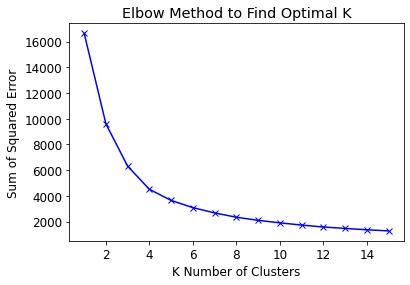

Using the elbow method, the optimal number of clusters is 4


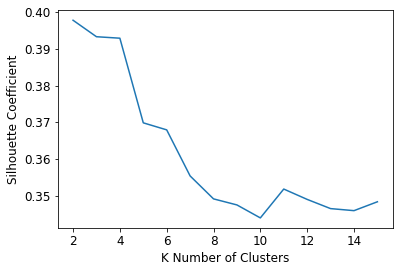

Using Silhouette Scores, the optimal number of clusters is 2


In [16]:
clusterFindK(data)

Lowest SSE 3644.9563258986195
Number of iterations needed for convergence 10
Y_km labels [4 4 2 ... 3 2 2]


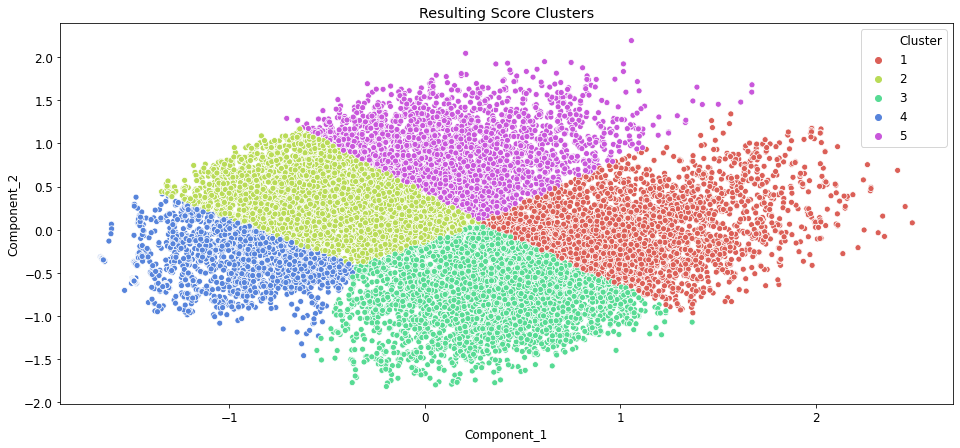

In [17]:
y_km = kMeans(data, 5)
pcaDF = plotPCAClusters(data, y_km, 5, 'AllData_ARIC_Cohort')

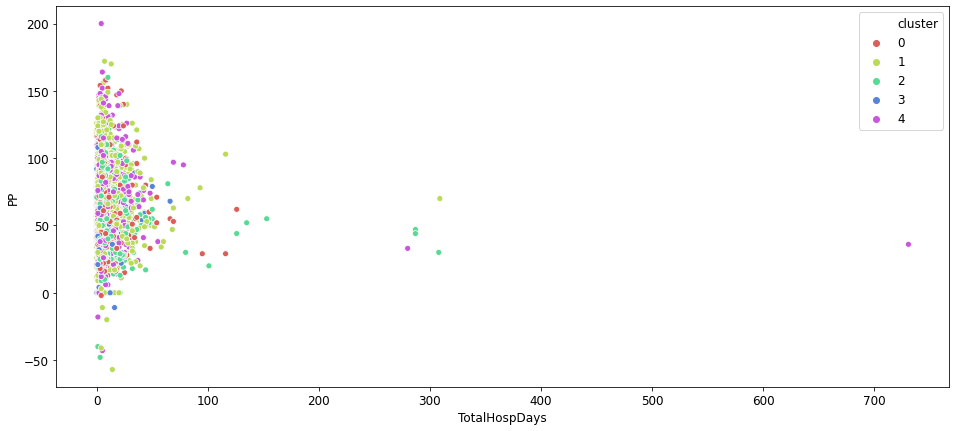

In [18]:
allDF = plotClusters(allDataCohort, y_km, ["TotalHospDays", "PP"], 5)

In [19]:
#Add class labels
allDF['Death'] = cohortLabels['Death']

clusters, clusterDesc = compareClusters(allDF, 5)

Cluster  0
               Age       Gender         Race           Wt          BMI  \
count  2809.000000  2809.000000  2809.000000  2371.000000  2701.000000   
mean     78.118904     1.338555     1.191883    83.989714    12.267826   
std       5.936040     0.473302     0.393852    19.855750    15.988714   
min      62.000000     1.000000     1.000000    32.295777     0.000000   
25%      74.000000     1.000000     1.000000    69.399633     0.000000   
50%      78.000000     1.000000     1.000000    81.450000     0.000000   
75%      82.000000     2.000000     1.000000    96.000000    26.532311   
max      93.000000     2.000000     2.000000   213.495000   189.446538   

       InitialHospDays  TotalHospDays        NYHA   MLHFS           AF  ...  \
count           2809.0    2809.000000  186.000000  2809.0  2809.000000  ...   
mean               0.0       6.379138    0.193548     0.0     0.862941  ...   
std                0.0       9.033517    0.739000     0.0     0.343971  ...   
min   

Cluster  4
               Age       Gender         Race           Wt          BMI  \
count  2573.000000  2573.000000  2573.000000  2194.000000  2473.000000   
mean     75.895064     1.531286     1.463272    85.064216     8.679648   
std       6.115645     0.499117     0.498746    19.935101    14.709003   
min      61.000000     1.000000     1.000000    26.807309     0.000000   
25%      71.000000     1.000000     1.000000    70.800000     0.000000   
50%      76.000000     2.000000     1.000000    83.300000     0.000000   
75%      80.000000     2.000000     2.000000    97.385500    22.634112   
max      91.000000     2.000000     2.000000   191.600000   200.413223   

       InitialHospDays  TotalHospDays        NYHA   MLHFS           AF  ...  \
count           2573.0    2570.000000  274.000000  2573.0  2573.000000  ...   
mean               0.0       7.170428    0.164234     0.0     0.049747  ...   
std                0.0      22.472970    0.704796     0.0     0.217465  ...   
min   

In [20]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_AllData_ARIC_Cohort.csv")

In [21]:
allDF.to_csv("Clustered_allDataDF_ARIC_Cohort.csv")

Save preprocessed data  
Cluster --> Score   

In [22]:
#Get means for each cluster

clsScDF = pd.DataFrame()
clsScDF.index.name = 'Cluster'

scores = [1,2,3,4,5]
dthMn = descSummary.loc['mean']['Death'].to_numpy()

In [23]:
dthScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(dthMn):
    dthScores[v] = scores[cnt]
    cnt += 1
    
clsScDF['DeathMean'] = dthMn
clsScDF['DeathScores'] = dthScores

clsScDF

,DeathMean,DeathScores
0,0.039160,2
1,0.046158,3
2,0.087571,4
3,0.093014,5
4,0.036533,1


Make sure to add final scores assignment

In [24]:
#Save fully preprocessed score data
clusNums = allDF['cluster']

#Death Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['DeathScores']))
allDF['ScoreDeath'] = labels

allDF = allDF.drop(columns=["cluster"])
allDF = allDF.drop(columns=["Death"])

allDF

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,EjF,BPDIAS,BPSYS,HR,PV,MAP,PP,PPP,PPRatio,ScoreDeath
ID,,,,,,,,,,,,,,,,,,,,,
S105655,76,1,1,NaN,0.000000,0,11.0,NaN,0,0,...,NaN,88.0,194.0,0,0,252.666667,106.0,0.546392,1.492958,1
S105655,76,1,1,NaN,NaN,0,11.0,NaN,0,0,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,1
S105737,76,2,1,67.70,0.000000,0,3.0,NaN,0,1,...,40.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,4
S105737,76,2,1,63.30,28.185923,0,3.0,NaN,0,1,...,40.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,4
S106083,66,2,1,86.00,0.000000,0,10.0,0.0,0,0,...,NaN,70.0,142.0,0,0,188.666667,72.0,0.507042,0.734694,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S214744,74,2,1,87.10,35.121038,0,3.0,NaN,0,1,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,2
S214752,80,2,1,66.90,0.000000,0,2.0,NaN,0,0,...,60.0,110.0,230.0,0,0,303.333333,120.0,0.521739,1.153846,3
S214752,80,2,1,67.10,24.616617,0,2.0,NaN,0,0,...,60.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,5


In [25]:
allDF.to_csv("../Data Validation/ARIC/Preprocessed Data/Clustered_AllData_ARIC_Cohort.csv")

## Hemo Dataset - Comm

In [26]:
#try clustering to find similar groups using PCA
hemo = copy.deepcopy(hemoComm)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)
scaler = MinMaxScaler()#scale data
hemo.loc[:,:] = scaler.fit_transform(hemo)
pca = PCA(n_components=2)
data = pca.fit_transform(hemo)

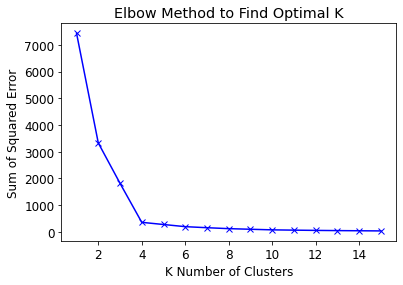

Using the elbow method, the optimal number of clusters is 4


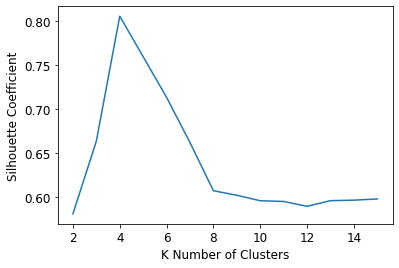

Using Silhouette Scores, the optimal number of clusters is 4


In [27]:
clusterFindK(data)

Lowest SSE 278.7063755385469
Number of iterations needed for convergence 7
Y_km labels [3 3 4 ... 1 3 1]


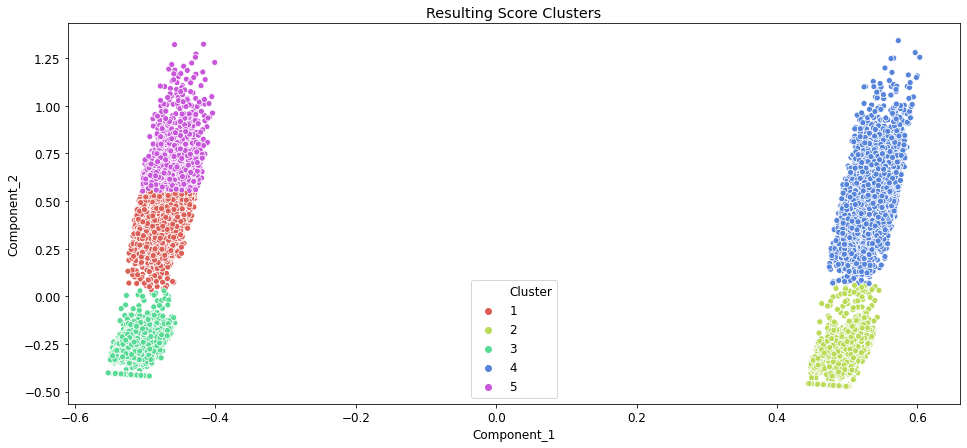

In [28]:
y_km = kMeans(data, 5)
pcaDF = plotPCAClusters(data, y_km, 5, "Hemo_ARIC_Comm")

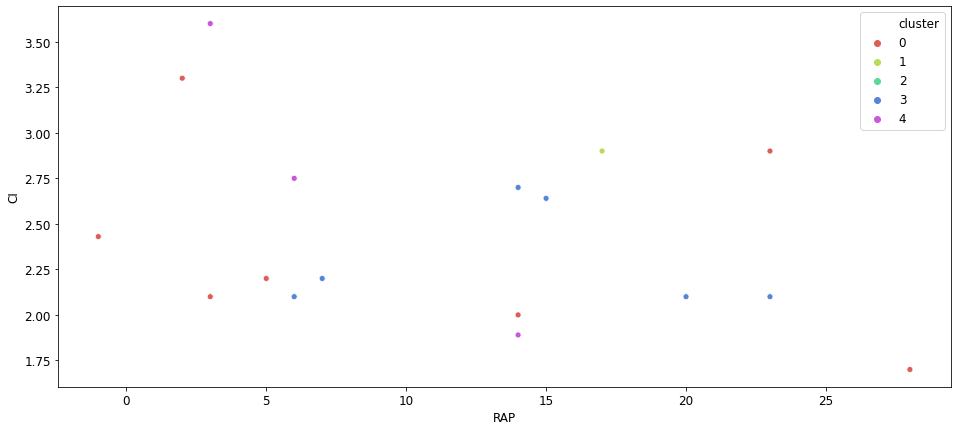

In [29]:
hemoDF = plotClusters(hemoComm, y_km, ["RAP", "CI"], 5)

In [30]:
#Add class labels
hemoDF['Death'] = cohortLabels['Death']

clusters, clusterDesc = compareClusters(hemoDF, 5)

Cluster  0
               Age  Gender    Race         EjF        RAP        PAS     PAD  \
count  1999.000000  1999.0  1999.0  966.000000  21.000000  18.000000  1999.0   
mean     70.773887     1.0     0.0   35.988613  14.333333  39.833333     0.0   
std       8.300470     0.0     0.0   16.246127  11.795479  12.682781     0.0   
min      55.000000     1.0     0.0    5.000000  -1.000000  20.000000     0.0   
25%      64.000000     1.0     0.0   22.000000   2.000000  32.000000     0.0   
50%      71.000000     1.0     0.0   35.000000  14.000000  35.000000     0.0   
75%      78.000000     1.0     0.0   50.000000  23.000000  51.000000     0.0   
max      84.000000     1.0     0.0   80.000000  34.000000  60.000000     0.0   

         PAMN       PCWP         CO  ...    PAPP          SVR        RAT  \
count  1999.0  18.000000  18.000000  ...  1999.0    14.000000  18.000000   
mean      0.0  16.500000   4.930000  ...     0.0  2278.093272   0.786296   
std       0.0   8.932755   1.542027  ...

In [31]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_Hemo_ARIC_Comm.csv")

In [32]:
hemoDF.to_csv("Clustered_HemoDF_ARIC_Comm.csv")

Save preprocessed data  
Cluster --> Score   

In [33]:
#Get means for each cluster

clsScDF = pd.DataFrame()
clsScDF.index.name = 'Cluster'

scores = [1,2,3,4,5]
dthMn = descSummary.loc['mean']['Death'].to_numpy()

In [34]:
dthScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(dthMn):
    dthScores[v] = scores[cnt]
    cnt += 1
    
clsScDF['DeathMean'] = dthMn
clsScDF['DeathScores'] = dthScores

clsScDF

,DeathMean,DeathScores
0,0.067485,3
1,0.053922,2
2,0.104294,5
3,0.069343,4
4,0.028571,1


Make sure to add final scores assignment

In [35]:
#Save fully preprocessed score data
clusNums = hemoDF['cluster']

#Death Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['DeathScores']))
hemoDF['ScoreDeath'] = labels

hemoDF = hemoDF.drop(columns=["cluster"])
hemoDF = hemoDF.drop(columns=["Death"])


hemoDF

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,PPP,PAPP,SVR,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,ScoreDeath
ID,,,,,,,,,,,,,,,,,,,,,
S106083,66,2,0,NaN,NaN,NaN,0,0,NaN,NaN,...,0.507042,0,NaN,NaN,0.734694,0,NaN,NaN,NaN,4
S106083,66,2,0,NaN,NaN,NaN,0,0,NaN,NaN,...,0.437500,0,NaN,NaN,0.571429,0,NaN,NaN,NaN,4
S106611,67,1,0,30.0,NaN,NaN,0,0,NaN,NaN,...,0.557292,0,NaN,NaN,1.445946,0,NaN,NaN,NaN,1
S106611,67,1,0,30.0,NaN,NaN,0,0,NaN,NaN,...,0.513514,0,NaN,NaN,1.027027,0,NaN,NaN,NaN,1
S106644,76,2,0,NaN,NaN,NaN,0,0,NaN,NaN,...,0.601227,0,NaN,NaN,1.126437,0,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S210889,80,2,0,20.0,NaN,NaN,0,0,NaN,NaN,...,0.444444,0,NaN,NaN,0.937500,0,NaN,NaN,NaN,4
S210906,82,2,0,NaN,NaN,NaN,0,0,NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,2
S210906,82,2,0,NaN,NaN,NaN,0,0,NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,2


In [36]:
hemoDF.to_csv("../Data Validation/ARIC/Preprocessed Data/Clustered_HemoDF_ARIC_Comm.csv")

## All Data - Cohort

In [37]:
#try clustering to find similar groups using PCA
allData = copy.deepcopy(allDataComm)
allData = allData.replace(np.inf, 0)
allData = allData.fillna(0)
scaler = MinMaxScaler()#scale data
allData.loc[:,:] = scaler.fit_transform(allData)
pca = PCA(n_components=2)
data = pca.fit_transform(allData)

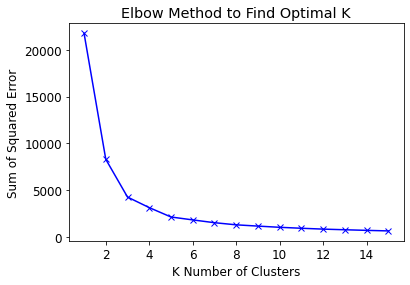

Using the elbow method, the optimal number of clusters is 3


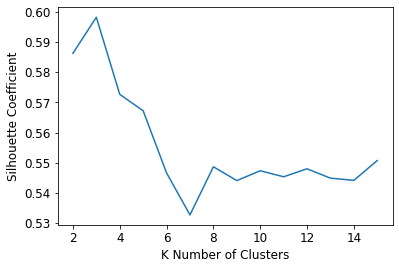

Using Silhouette Scores, the optimal number of clusters is 3


In [38]:
clusterFindK(data)

Lowest SSE 2136.9889957728647
Number of iterations needed for convergence 11
Y_km labels [4 3 4 ... 1 4 3]


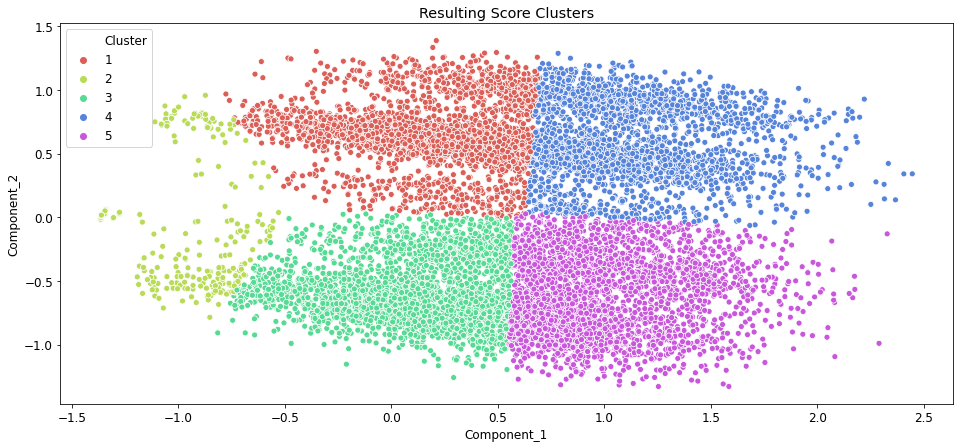

In [39]:
y_km = kMeans(data, 5)
pcaDF = plotPCAClusters(data, y_km, 5, 'AllData_ARIC_Comm')

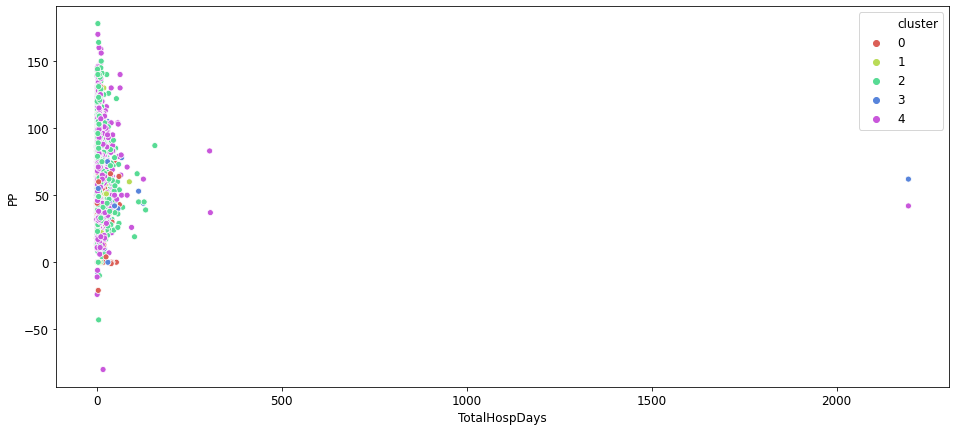

In [40]:
allDF = plotClusters(allDataComm, y_km, ["TotalHospDays", "PP"], 5)

In [41]:
#Add class labels
allDF['Death'] = cohortLabels['Death']

clusters, clusterDesc = compareClusters(allDF, 5)

Cluster  0
               Age       Gender    Race           Wt          BMI  \
count  2850.000000  2850.000000  2850.0  2056.000000  2370.000000   
mean     70.800351     1.518596     0.0    85.966207    30.142763   
std       8.520069     0.499742     0.0    29.772950    12.079075   
min      55.000000     1.000000     0.0    23.425324     0.000000   
25%      64.000000     1.000000     0.0    66.215000    23.268489   
50%      71.000000     2.000000     0.0    80.890000    27.985976   
75%      78.000000     2.000000     0.0   100.132500    35.042270   
max      84.000000     2.000000     0.0   567.600000   172.176309   

       InitialHospDays  TotalHospDays        NYHA   MLHFS           AF  ...  \
count           2850.0    2850.000000  179.000000  2850.0  2850.000000  ...   
mean               0.0       7.982807    0.050279     0.0     0.221754  ...   
std                0.0       9.361470    0.386191     0.0     0.415500  ...   
min                0.0       0.000000    0.000000  

Cluster  4
               Age       Gender    Race           Wt          BMI  \
count  2920.000000  2920.000000  2920.0  2571.000000  2889.000000   
mean     70.619178     1.477055     0.0    88.706015     1.841579   
std       8.260543     0.499559     0.0    22.128746     7.875561   
min      55.000000     1.000000     0.0    22.452822     0.000000   
25%      64.000000     1.000000     0.0    72.574779     0.000000   
50%      71.000000     1.000000     0.0    86.182550     0.000000   
75%      78.000000     2.000000     0.0   102.073000     0.000000   
max      85.000000     2.000000     0.0   196.300000    76.660521   

       InitialHospDays  TotalHospDays        NYHA   MLHFS           AF  ...  \
count           2920.0    2920.000000  287.000000  2920.0  2920.000000  ...   
mean               0.0       8.021233    0.212544     0.0     0.413356  ...   
std                0.0      41.941707    0.819421     0.0     0.492520  ...   
min                0.0       0.000000    0.000000  

In [42]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_AllData_ARIC_Comm.csv")

In [43]:
allDF.to_csv("Clustered_allDataDF_ARIC_Comm.csv")

Save preprocessed data  
Cluster --> Score   

In [44]:
#Get means for each cluster

clsScDF = pd.DataFrame()
clsScDF.index.name = 'Cluster'

scores = [1,2,3,4,5]
dthMn = descSummary.loc['mean']['Death'].to_numpy()

In [45]:
dthScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(dthMn):
    dthScores[v] = scores[cnt]
    cnt += 1
    
clsScDF['DeathMean'] = dthMn
clsScDF['DeathScores'] = dthScores

clsScDF

,DeathMean,DeathScores
0,0.131313,4
1,0.140000,5
2,0.055556,2
3,0.014851,1
4,0.057522,3


Make sure to add final scores assignment

In [46]:
#Save fully preprocessed score data
clusNums = allDF['cluster']

#Death Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['DeathScores']))
allDF['ScoreDeath'] = labels

allDF = allDF.drop(columns=["cluster"])
allDF = allDF.drop(columns=["Death"])

allDF

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,EjF,BPDIAS,BPSYS,HR,PV,MAP,PP,PPP,PPRatio,ScoreDeath
ID,,,,,,,,,,,,,,,,,,,,,
S106083,66,2,0,86.000,0.000000,0,10,0.0,0,0,...,NaN,70.0,142.0,0,0,188.666667,72.0,0.507042,0.734694,3
S106083,66,2,0,88.500,36.865164,0,10,0.0,0,0,...,NaN,72.0,128.0,0,0,176.000000,56.0,0.437500,0.571429,1
S106611,67,1,0,80.200,0.000000,0,5,4.0,0,0,...,30.0,85.0,192.0,0,0,248.666667,107.0,0.557292,1.445946,3
S106611,67,1,0,75.000,24.417188,0,5,4.0,0,0,...,30.0,72.0,148.0,0,0,196.000000,76.0,0.513514,1.027027,3
S106644,76,2,0,57.200,0.000000,0,5,0.0,0,1,...,NaN,65.0,163.0,0,0,206.333333,98.0,0.601227,1.126437,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S210889,80,2,0,55.792,20.468112,0,5,NaN,0,1,...,20.0,75.0,135.0,0,0,185.000000,60.0,0.444444,0.937500,4
S210906,82,2,0,NaN,0.000000,0,3,NaN,0,0,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,5
S210906,82,2,0,NaN,NaN,0,3,NaN,0,0,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,5


In [47]:
allDF.to_csv("../Data Validation/ARIC/Preprocessed Data/Clustered_AllData_ARIC_Comm.csv")